# Analyzing business potential of areas in Pune, India

### Table of contents

[1. Deciding initial search locations and getting their coordinates](#one)

[2. Searching for venues around areas with prospects (using Foursquare API)](#two)

[3. Visualizing all venues on map](#three)

[4. Clustering the venues](#four)

[5. Visualizing the clusters on map](#five)

[6. Analyzing the clusters](#six)

[7. Analyzing connectivity by road to business areas](#seven)

[8. Locating the banks and ATM's near business areas](#eight)

[9. Conclusion](#nine)

### Deciding initial search locations and getting their coordinates <a name="one"></a>

#### Importing required libraries

In [4]:
import pandas as pd
import numpy as np
from geopy.geocoders import Nominatim      # geolocation library
import requests                          # to handle requests to urls

#### Function to get coordinates from list of address

Using Nominatim() for geolocation from geopy library to get the value of latitude and longitude from address

In [5]:
def get_coordinates(address_list):
    geolocator = Nominatim(user_agent="wain")
    locations = pd.DataFrame(columns=['Area name', 'latitude', 'longitude'])
    for address in address_list:
        try:
            location = geolocator.geocode(address)
            latitude = location.latitude
            longitude = location.longitude
        except:                                  # incase the address entered is not found, an exception will be thrown.
            latitude = 'Address not found'
            longitude = 'Address not found'
        locations = locations.append(
            {
                'Area name': address,
                'latitude': latitude,
                'longitude': longitude
            },
            ignore_index=True)
    return locations

#### Making a dataframe of locations around which to search for venues using Foursquare API

The areas I selected are surrounded by the most bustling business locations. I selected the first five locations in the list below initially, but not whole city of Pune was covered. So later I added 6th location.

In [6]:
# list of areas that I decided upon, venues around these locations will be used
address = ['Shankar Kalat nagar','Pimpri-Chinchwad','Aundh,Pune','Kothrud','Koregaon Park','Hadapsar']
locations = get_coordinates(address)
locations

,Area name,latitude,longitude
0,Shankar Kalat nagar,18.604093,73.754065
1,Pimpri-Chinchwad,18.627929,73.800983
2,"Aundh,Pune",18.561883,73.810196
3,Kothrud,18.503889,73.807673
4,Koregaon Park,18.537553,73.893925
5,Hadapsar,18.526967,73.927825


### Searching for venues around areas with prospects (using Foursquare API)<a name="two"></a>

#### Defining Foursquare credentials

In [7]:
# hide this cell
# credential foursquare API
CLIENT_ID = 'DMMNDCKP4HCEBKNG0OZUKP4HQ4G2ARKETXFJLZOI1DY001IT' # your Foursquare ID
CLIENT_SECRET = 'BNOTBJCDHCHRJ3Z1EAMLB0TXSCA4RUH1HSABRTIV33ERSMAM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### A function to get list of venues around a coordinate

In [8]:
import json
from pandas.io.json import json_normalize

Using the Foursquare API to get list of venues around the coordinates passed

In [9]:
def get_venues(lat, lon):
    LIMIT = 100
    radius = 5000
    try:
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lon, radius, LIMIT)
        results = requests.get(url).json()
        venues = results['response']['groups'][0]['items']
        nearby_venues = json_normalize(venues)  # flatten JSON
        filtered_columns = [
            'venue.name', 'venue.categories', 'venue.location.lat',
            'venue.location.lng'
        ]
        nearby_venues = nearby_venues.loc[:, filtered_columns]
        nearby_venues['venue.categories'] = nearby_venues.apply(
            get_category_type, axis=1)
        nearby_venues.columns = [
            col.split(".")[-1] for col in nearby_venues.columns
        ]

    except:
        return None

    return nearby_venues

####  Function that extracts the category of the venue-->   Function obtained from Foursquare lab.

In [10]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Making a dataframe containing the venues and their coordinates.

In [11]:
df_venues = pd.DataFrame(columns=['name','categories','lat','lng'])
for i in range (0,len(locations.index)):
    df_venues = df_venues.append(get_venues(locations.latitude[i],locations.longitude[i]))
    
df_venues.shape

C:\Users\jkfra\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  if __name__ == '__main__':


(553, 4)

The index in dataframe will repeat starting from 0 for each of the six locations in the above loop. Hence there is a need to set the index in order

In [12]:
df_venues.reset_index(drop=True, inplace=True)
df_venues.head()

,name,categories,lat,lng
0,Sayaji,Hotel,18.599535,73.754995
1,Little Italy,Italian Restaurant,18.591513,73.743668
2,MoMo Cafe,Indian Restaurant,18.591650,73.747011
3,Courtyard by Marriott,Hotel,18.591591,73.746877
4,Shaolin- The Chinese Cuisine,Chinese Restaurant,18.588343,73.783514


The radius for search around the initial locations was km. There was probability of same venues existing in the range of search radius from two areas. Therefore removing duplicate venue rows.

In [13]:
df_venues = df_venues.drop_duplicates()

It can be seen from the shape of the df_venues dataframe that there were some duplicate venues present. The initial number of rows where 594 and 488 rows after removing duplicates.

In [14]:
df_venues.shape

(437, 4)

### Visualizing all venues on map<a name="three"></a>

Using Folium library for plotting the venues

In [15]:
import folium

In [16]:
map_ = folium.Map(location=[locations.latitude[2], locations.longitude[2]], zoom_start=12)

# add markers to map
for lat, lng, Categories, name in zip(df_venues['lat'], df_venues['lng'], df_venues['categories'], df_venues['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_)  
    
map_

In [17]:
df_venues.to_csv('venues_all.csv',index=False)   # exporting csv for tests

### Clustering the venues<a name="four"></a>

#### Preparing the dataset for clustering algorithm

In [18]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from folium import plugins
import matplotlib.pyplot as plt

Getting only the coordinates of the venues. Other columns like categories and name will only make it difficult to classify the data into clusters. I wanted the clusters to formed based on the locations only. This way it will be easy to identify the areas with good business prospects.

In [19]:
Clus_dataSet = df_venues[['lat','lng']] 
Clus_dataSet.head()

,lat,lng
0,18.599535,73.754995
1,18.591513,73.743668
2,18.591650,73.747011
3,18.591591,73.746877
4,18.588343,73.783514


Scaling the value of coordinates so that the algorithm clusters more accurately. If data is not scaled, the number of clusters is very low or only 1 cluster in some cases.

In [20]:
scaler = StandardScaler()
Clus_dataSet_scale = scaler.fit_transform(Clus_dataSet)
Clus_dataSet_scale[0:5]

array([[ 1.12059705, -1.36346504],
       [ 0.92689667, -1.5616871 ],
       [ 0.93020864, -1.50318116],
       [ 0.92878855, -1.50551954],
       [ 0.85036777, -0.86440237]])

#### Using K-means to cluster venues

I also tested the clusters using DBSCAN, the resulting clusters were good. There were 7 clusters but with some outliers. I would have had to process these outliers seperately or add them to the nearest clusters. The k-means also clustered them into 5 clusters with good distribution according to area. Though not as detailed as DBSCAN but I still decided to use K-means.

#### Finding the best K

In [21]:
dist = []
list_k = list(range(1, 12))      # list of values of k to test for

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(Clus_dataSet_scale)
    dist.append(km.inertia_)   

Using elbow method for finding best k

Text(0, 0.5, 'Sum of squared distance')

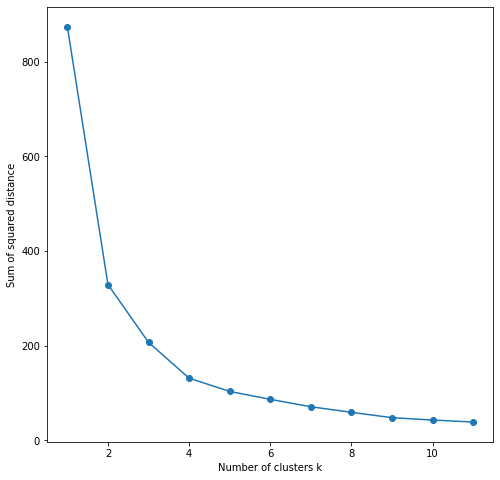

In [22]:
# Plot dist against k
plt.figure(figsize=(8, 8))
plt.plot(list_k, dist, '-o')
plt.xlabel('Number of clusters k')
plt.ylabel('Sum of squared distance')

There is no proper elbow seen in the graph. So I decided to use k=5. The graph starts to straighten out after this point with almost no change in slope.

#### Fitting the data on K-means algorithm

In [23]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet_scale)

# check cluster labels generated for each row in the dataframe
labels = kmeans.labels_
labels[:50]

array([3, 3, 3, 3, 3, 3, 3, 0, 0, 3, 0, 2, 2, 0, 3, 3, 3, 3, 3, 0, 3, 3,
       0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 2, 3, 0,
       3, 3, 3, 3, 3, 0])

### Visualizing the clusters on map<a name="five"></a>

In [24]:
color_options = [
    'black', 'blue', 'red', 'purple', 'darkgreen', 'darkpurple',
    'darkred', 'gray', 'green', 'lightblue', 'lightgreen', 'lightred',
    'orange', 'pink'
]
map_clus = folium.Map(location=[locations.latitude[2], locations.longitude[2]],
                      zoom_start=11)
# add markers to map
for lat, lng, Categories, name, lab in zip(df_venues['lat'], df_venues['lng'],
                                           df_venues['categories'],
                                           df_venues['name'], labels):
    label = '{}, {}'.format(name, Categories, lab)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                        radius=1,
                        popup=label,
                        color=color_options[lab],
                        fill=True,
                        fill_opacity=1,
                        parse_html=False).add_to(map_clus)

map_clus

### Analyzing the clusters<a name="six"></a>

#### Adding Cluster labels column to separate dataframe according to cluster

In [25]:
df_venues.insert(0, 'Cluster Labels', labels)
df_venues.head()

,Cluster Labels,name,categories,lat,lng
0,3,Sayaji,Hotel,18.599535,73.754995
1,3,Little Italy,Italian Restaurant,18.591513,73.743668
2,3,MoMo Cafe,Indian Restaurant,18.591650,73.747011
3,3,Courtyard by Marriott,Hotel,18.591591,73.746877
4,3,Shaolin- The Chinese Cuisine,Chinese Restaurant,18.588343,73.783514


#### Function for getting address from coordinates

Using Nominatim() from geopy library for reverse geolocation.

In [26]:
def get_address(coordinates_list):
    reverse_geolocator = Nominatim(user_agent="wain")
    area_name = []
    for coord in coordinates_list:
        try:
            address = reverse_geolocator.reverse(coord)
            x = str(address)
            area_name.append(x.split(',')[-6])
        except:
            x = 'Address not found'
            area_name.append(x)        
    return area_name

#### Preparing dataframe for Cluster with label 0

In [27]:
Cluster_0 = df_venues.loc[df_venues['Cluster Labels'] == 0]
Cluster_0.reset_index(drop=True, inplace=True)        # index will be taken from original df, hence need to reset index
Cluster_0.head()

,Cluster Labels,name,categories,lat,lng
0,0,Urban Foundry,Lounge,18.569289,73.774725
1,0,Incognito,Italian Restaurant,18.570376,73.774607
2,0,Playboy Beer Garden,Brewery,18.570494,73.773901
3,0,Terttulia,Bistro,18.569280,73.774695
4,0,Way Down South,South Indian Restaurant,18.566366,73.770707


Converting to list to get the area name from address

In [28]:
Cluster_0_coord = Cluster_0[['lat','lng']].values.tolist()
Cluster_0_coord[:5]

[[18.569289409666702, 73.7747245463514],
 [18.570376414375, 73.77460705928516],
 [18.57049357355062, 73.77390083744952],
 [18.569279945639824, 73.77469467616115],
 [18.56636563963199, 73.77070666006395]]

Getting a list of area name for each venue using reverse geolocation

In [29]:
area_name = get_address(Cluster_0_coord)
area_name[:5]

[' Baner', ' Baner', ' Baner', ' Baner', ' Baner']

In [30]:
Cluster_0.insert(0, 'Area_name', area_name)
Cluster_0.head()

,Area_name,Cluster Labels,name,categories,lat,lng
0,Baner,0,Urban Foundry,Lounge,18.569289,73.774725
1,Baner,0,Incognito,Italian Restaurant,18.570376,73.774607
2,Baner,0,Playboy Beer Garden,Brewery,18.570494,73.773901
3,Baner,0,Terttulia,Bistro,18.569280,73.774695
4,Baner,0,Way Down South,South Indian Restaurant,18.566366,73.770707


#### Preparing dataframes for clusters with labels 1,2,3 and 4

In [31]:
Cluster_1 = df_venues.loc[df_venues['Cluster Labels'] == 1]
Cluster_1.reset_index(drop=True, inplace=True)
Cluster_1_coord = Cluster_1[['lat','lng']].values.tolist()
area_name = get_address(Cluster_1_coord)
Cluster_1.insert(0, 'Area_name', area_name)
Cluster_1.head()

,Area_name,Cluster Labels,name,categories,lat,lng
0,Ghorpuri,1,Boteco,Brazilian Restaurant,18.534252,73.899297
1,Ghorpuri,1,Malaka Spice,Asian Restaurant,18.537519,73.897719
2,Ghorpuri,1,the French Window Patisserie,Bakery,18.537709,73.897990
3,Ghorpuri,1,Naughty Angel Cafe,Café,18.536556,73.899664
4,Ghorpuri,1,Savya Rasa,South Indian Restaurant,18.538874,73.886561


In [32]:
Cluster_2 = df_venues.loc[df_venues['Cluster Labels'] == 2]
Cluster_2.reset_index(drop=True, inplace=True)
Cluster_2_coord = Cluster_2[['lat','lng']].values.tolist()
area_name = get_address(Cluster_2_coord)
Cluster_2.insert(0, 'Area_name', area_name)
Cluster_2.head()

,Area_name,Cluster Labels,name,categories,lat,lng
0,Chinchwad,2,Nevale Misal,Fast Food Restaurant,18.627925,73.780808
1,Chinchwad,2,Bakers Hut,Bakery,18.642342,73.773437
2,Chinchwad,2,Domino's Pizza,Pizza Place,18.630000,73.788000
3,Chinchwad,2,McDonald's,Fast Food Restaurant,18.623647,73.786398
4,Chinchwad,2,Bay Leaf Bistro,Indian Restaurant,18.624703,73.784077


In [33]:
Cluster_3 = df_venues.loc[df_venues['Cluster Labels'] == 3]
Cluster_3.reset_index(drop=True, inplace=True)
Cluster_3_coord = Cluster_3[['lat','lng']].values.tolist()
area_name = get_address(Cluster_3_coord)
Cluster_3.insert(0, 'Area_name', area_name)
Cluster_3.head()

,Area_name,Cluster Labels,name,categories,lat,lng
0,Wakad,3,Sayaji,Hotel,18.599535,73.754995
1,Hinjawadi Phase 1,3,Little Italy,Italian Restaurant,18.591513,73.743668
2,Hinjawadi Phase 1,3,MoMo Cafe,Indian Restaurant,18.591650,73.747011
3,Hinjawadi Phase 1,3,Courtyard by Marriott,Hotel,18.591591,73.746877
4,Kaspate Vasti,3,Shaolin- The Chinese Cuisine,Chinese Restaurant,18.588343,73.783514


In [34]:
Cluster_4 = df_venues.loc[df_venues['Cluster Labels'] == 4]
Cluster_4.reset_index(drop=True, inplace=True)
Cluster_4_coord = Cluster_4[['lat','lng']].values.tolist()
area_name = get_address(Cluster_4_coord)
Cluster_4.insert(0, 'Area_name', area_name)
Cluster_4.head()

,Area_name,Cluster Labels,name,categories,lat,lng
0,Model Colony,4,Kiva,Lounge,18.538459,73.836863
1,Model Colony,4,JW Marriott Hotel Pune,Hotel,18.532415,73.829773
2,Model Colony,4,Spice Kitchen,Asian Restaurant,18.531887,73.829571
3,Model Colony,4,Paasha,Lounge,18.532077,73.829564
4,Model Colony,4,Pune Baking Company,Bakery,18.531972,73.829834


#### Function to get the top ten venues in each area of a cluster

In [35]:
def get_top_venues(cluster_venues):
    # one hot encoding
    cluster_onehot = pd.get_dummies(cluster_venues[['categories']], prefix="", prefix_sep="")

    # add area name column back to dataframe
    cluster_onehot['Area_name'] = cluster_venues['Area_name'] 

    # move neighborhood column to the first column
    fixed_columns = [cluster_onehot.columns[-1]] + list(cluster_onehot.columns[:-1])
    cluster_onehot = cluster_onehot[fixed_columns]
    cluster_grouped = cluster_onehot.groupby('Area_name').mean().reset_index()
    
    num_top_venues = 10
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Area_name']
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    area_venues_sorted = pd.DataFrame(columns=columns)
    area_venues_sorted['Area_name'] = cluster_grouped['Area_name']

    for ind in np.arange(cluster_grouped.shape[0]):
        area_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cluster_grouped.iloc[ind, :], num_top_venues)

    return area_venues_sorted

Function to sort venues in descending order

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Analyzing cluster 0

Visualizing Cluster 0 on map

In [37]:
map_0 = folium.Map(location=[Cluster_0['lat'][0], Cluster_0['lng'][0]], zoom_start=13)

# add markers to map
for lat, lng, Categories, name in zip(Cluster_0['lat'], Cluster_0['lng'], Cluster_0['categories'], Cluster_0['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_0)  
    
map_0

It can be seen on the map that areas Pimple saudagar, Pimple nilakh, balewadi, Aundh and Pashan fall under cluster_0.

In [38]:
Cluster_0_top_venues = get_top_venues(Cluster_0)
Cluster_0_top_venues

,Area_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aundh,Ice Cream Shop,Coffee Shop,Mexican Restaurant,Korean Restaurant,Indian Restaurant,Restaurant,Gym,Grocery Store,Shopping Mall,Fast Food Restaurant
1,Baner,Indian Restaurant,South Indian Restaurant,Fast Food Restaurant,Café,Lounge,Punjabi Restaurant,Pizza Place,Italian Restaurant,Bar,Bistro
2,Juni Sangvi,Snack Place,Coffee Shop,Bar,Molecular Gastronomy Restaurant,Juice Bar,Korean Restaurant,Lounge,Malay Restaurant,Mexican Restaurant,Punjabi Restaurant
3,Kasarwadi,Restaurant,Bar,Indian Restaurant,South Indian Restaurant,Snack Place,Shopping Mall,Sandwich Place,Punjabi Restaurant,Pizza Place,Molecular Gastronomy Restaurant
4,Khadki,Indian Restaurant,Bar,South Indian Restaurant,Snack Place,Shopping Mall,Sandwich Place,Restaurant,Punjabi Restaurant,Pizza Place,Molecular Gastronomy Restaurant
5,Pashan,Food Court,Bar,Molecular Gastronomy Restaurant,Juice Bar,Korean Restaurant,Lounge,Malay Restaurant,Mexican Restaurant,Pizza Place,Indian Restaurant
6,Pune City,Hotel,Bar,Molecular Gastronomy Restaurant,Juice Bar,Korean Restaurant,Lounge,Malay Restaurant,Mexican Restaurant,Pizza Place,Indian Restaurant
7,Aundh,Vegetarian / Vegan Restaurant,Chinese Restaurant,Donut Shop,Indian Restaurant,Shopping Mall,Snack Place,Sandwich Place,Restaurant,Punjabi Restaurant,Italian Restaurant
8,Baner,Indian Restaurant,Bar,South Indian Restaurant,Snack Place,Shopping Mall,Sandwich Place,Restaurant,Punjabi Restaurant,Pizza Place,Molecular Gastronomy Restaurant
9,Bavdhan Budruk,Indian Restaurant,Bar,South Indian Restaurant,Snack Place,Shopping Mall,Sandwich Place,Restaurant,Punjabi Restaurant,Pizza Place,Molecular Gastronomy Restaurant


It can be seen that there are 10 different areas in CLuster_0. All the most common venues can be seen according to area.

In [39]:
Cluster_0.categories.nunique()

33

In [40]:
Cluster_0.categories.value_counts()

Indian Restaurant                  14
Fast Food Restaurant                6
Café                                4
South Indian Restaurant             4
Coffee Shop                         3
Lounge                              3
Ice Cream Shop                      3
Shopping Mall                       2
Chinese Restaurant                  2
Dessert Shop                        2
Snack Place                         2
Italian Restaurant                  2
Restaurant                          2
Brewery                             2
Punjabi Restaurant                  2
Pizza Place                         2
Vegetarian / Vegan Restaurant       1
Mexican Restaurant                  1
Grocery Store                       1
Sandwich Place                      1
Gym                                 1
Bookstore                           1
Department Store                    1
Bar                                 1
Hotel                               1
Bistro                              1
Malay Restau

#### Analyzing cluster 1

In [41]:
map_1 = folium.Map(location=[Cluster_1['lat'][0], Cluster_1['lng'][0]], zoom_start=13)

# add markers to map
for lat, lng, Categories, name in zip(Cluster_1['lat'], Cluster_1['lng'], Cluster_1['categories'], Cluster_1['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_1)  
    
map_1

In [42]:
Cluster_1_top_venues = get_top_venues(Cluster_1)
Cluster_1_top_venues

,Area_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amrutlal Mehta Path,Italian Restaurant,Asian Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Multicuisine Indian Restaurant,Multiplex
1,Boat Club Road,Bakery,Pub,American Restaurant,Pizza Place,Juice Bar,Kebab Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Multicuisine Indian Restaurant
2,Dhole Patil Road,Kebab Restaurant,American Restaurant,Asian Restaurant,Jazz Club,Juice Bar,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Multicuisine Indian Restaurant,Multiplex
3,Fatima Nagar,Pizza Place,Asian Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Multicuisine Indian Restaurant,Multiplex
4,Ganesh Peth,Breakfast Spot,American Restaurant,Pizza Place,Juice Bar,Kebab Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Multicuisine Indian Restaurant,Multiplex
5,Ghorpuri,Italian Restaurant,Bakery,Indian Restaurant,Café,Asian Restaurant,Ice Cream Shop,Hotel,Organic Grocery,Pub,Restaurant
6,Kalyani Nagar,Pub,American Restaurant,Gym,Sandwich Place,Park,Jazz Club,Italian Restaurant,Indian Chinese Restaurant,Gym / Fitness Center,Indian Restaurant
7,Kharadi,Coffee Shop,Hotel,Pizza Place,Juice Bar,Kebab Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Multicuisine Indian Restaurant,Multiplex
8,Koregaon Road,Hotel,Multicuisine Indian Restaurant,American Restaurant,Italian Restaurant,Juice Bar,Kebab Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Multiplex
9,Mangaldas Road,Hotel,American Restaurant,Italian Restaurant,Juice Bar,Kebab Restaurant,Lounge,Mediterranean Restaurant,Middle Eastern Restaurant,Multicuisine Indian Restaurant,Multiplex


In [43]:
Cluster_1.categories.nunique()

56

In [44]:
Cluster_0.categories.value_counts()

Indian Restaurant                  14
Fast Food Restaurant                6
Café                                4
South Indian Restaurant             4
Coffee Shop                         3
Lounge                              3
Ice Cream Shop                      3
Shopping Mall                       2
Chinese Restaurant                  2
Dessert Shop                        2
Snack Place                         2
Italian Restaurant                  2
Restaurant                          2
Brewery                             2
Punjabi Restaurant                  2
Pizza Place                         2
Vegetarian / Vegan Restaurant       1
Mexican Restaurant                  1
Grocery Store                       1
Sandwich Place                      1
Gym                                 1
Bookstore                           1
Department Store                    1
Bar                                 1
Hotel                               1
Bistro                              1
Malay Restau

#### Analyzing cluster 2

In [45]:
map_2 = folium.Map(location=[Cluster_2['lat'][0], Cluster_2['lng'][0]], zoom_start=13)

# add markers to map
for lat, lng, Categories, name in zip(Cluster_2['lat'], Cluster_2['lng'], Cluster_2['categories'], Cluster_2['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_2)  
    
map_2

In [46]:
Cluster_2_top_venues = get_top_venues(Cluster_2)
Cluster_2_top_venues

,Area_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Chinchwad,Fast Food Restaurant,Hotel,Indian Restaurant,Pizza Place,Snack Place,Restaurant,Multiplex,Middle Eastern Restaurant,Mexican Restaurant,Market
1,Kasarwadi,Fast Food Restaurant,Asian Restaurant,Indian Restaurant,Snack Place,Restaurant,Pizza Place,Multiplex,Middle Eastern Restaurant,Mexican Restaurant,Market
2,Nigdi,Café,Pizza Place,Snack Place,Coffee Shop,Diner,Middle Eastern Restaurant,Indian Restaurant,Asian Restaurant,Market,Restaurant
3,Pimpri,Market,Asian Restaurant,Indian Restaurant,Snack Place,Restaurant,Pizza Place,Multiplex,Middle Eastern Restaurant,Mexican Restaurant,Italian Restaurant
4,Pimpri-Chinchwad,Indian Restaurant,Hotel,Café,Coffee Shop,Department Store,Pizza Place,Market,Snack Place,Restaurant,Multiplex
5,Sudershan Nagar,Indian Restaurant,Asian Restaurant,Snack Place,Restaurant,Pizza Place,Multiplex,Middle Eastern Restaurant,Mexican Restaurant,Market,Italian Restaurant
6,Address not found,Pizza Place,Gym,Asian Restaurant,Indian Restaurant,Snack Place,Restaurant,Multiplex,Middle Eastern Restaurant,Mexican Restaurant,Market
7,Chinchwad,Indian Restaurant,Italian Restaurant,Bakery,Asian Restaurant,Snack Place,Restaurant,Pizza Place,Multiplex,Middle Eastern Restaurant,Mexican Restaurant
8,Nigdi,Asian Restaurant,Snack Place,Multiplex,Mexican Restaurant,Food Court,Indian Restaurant,Restaurant,Pizza Place,Middle Eastern Restaurant,Market
9,Pimpri,Tea Room,Indian Restaurant,Snack Place,Restaurant,Pizza Place,Multiplex,Middle Eastern Restaurant,Mexican Restaurant,Market,Italian Restaurant


In [47]:
Cluster_2.categories.nunique()

21

In [48]:
Cluster_2.categories.value_counts()

Indian Restaurant            6
Pizza Place                  6
Fast Food Restaurant         5
Hotel                        3
Café                         3
Asian Restaurant             2
Snack Place                  2
Coffee Shop                  2
Food Court                   2
Middle Eastern Restaurant    1
Italian Restaurant           1
Chinese Restaurant           1
Mexican Restaurant           1
Bakery                       1
Gym                          1
Department Store             1
Restaurant                   1
Tea Room                     1
Market                       1
Diner                        1
Multiplex                    1
Name: categories, dtype: int64

#### Analyzing cluster 3

In [49]:
map_3 = folium.Map(location=[Cluster_3['lat'][0], Cluster_3['lng'][0]], zoom_start=13)

# add markers to map
for lat, lng, Categories, name in zip(Cluster_3['lat'], Cluster_3['lng'], Cluster_3['categories'], Cluster_3['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_3)  
    
map_3

In [50]:
Cluster_3_top_venues = get_top_venues(Cluster_3)
Cluster_3_top_venues

,Area_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hinjawadi Phase 1,Sandwich Place,Hotel,Italian Restaurant,Café,Chinese Restaurant,Pizza Place,Fast Food Restaurant,Mexican Restaurant,Market,Snack Place
1,Hinjawadi Phase 2 Road,Coffee Shop,Andhra Restaurant,Lounge,Snack Place,Sandwich Place,Restaurant,Pizza Place,Multiplex,Multicuisine Indian Restaurant,Motel
2,Kaspate Vasti,Indian Restaurant,Snack Place,Café,Chinese Restaurant,Andhra Restaurant,Market,Sandwich Place,Restaurant,Pizza Place,Multiplex
3,Mhalunge,Stadium,Multicuisine Indian Restaurant,Hotel,Lounge,Snack Place,Sandwich Place,Restaurant,Pizza Place,Multiplex,Motel
4,Pimple Saudagar,Sandwich Place,Pizza Place,Andhra Restaurant,Café,Restaurant,Fast Food Restaurant,Gym,Indian Restaurant,Lounge,Market
5,Punawale,Fast Food Restaurant,Indian Restaurant,Andhra Restaurant,Lounge,Snack Place,Sandwich Place,Restaurant,Pizza Place,Multiplex,Multicuisine Indian Restaurant
6,Sus Gaon,Café,Andhra Restaurant,Lounge,Snack Place,Sandwich Place,Restaurant,Pizza Place,Multiplex,Multicuisine Indian Restaurant,Motel
7,Thergaon,Sandwich Place,Hotel,Andhra Restaurant,Lounge,Snack Place,Restaurant,Pizza Place,Multiplex,Multicuisine Indian Restaurant,Motel
8,Wakad,Indian Restaurant,Café,Fast Food Restaurant,Hotel,BBQ Joint,Andhra Restaurant,Mexican Restaurant,Snack Place,Sandwich Place,Restaurant
9,Address not found,Sandwich Place,Restaurant,Andhra Restaurant,BBQ Joint,Snack Place,Pizza Place,Multiplex,Multicuisine Indian Restaurant,Motel,Mexican Restaurant


In [51]:
Cluster_3.categories.nunique()

24

In [52]:
Cluster_3.categories.value_counts()

Indian Restaurant                 16
Sandwich Place                     6
Pizza Place                        5
Fast Food Restaurant               5
Café                               5
Hotel                              5
Snack Place                        3
Chinese Restaurant                 3
Restaurant                         2
Stadium                            2
Andhra Restaurant                  1
Market                             1
Mexican Restaurant                 1
Italian Restaurant                 1
Motel                              1
Multicuisine Indian Restaurant     1
BBQ Joint                          1
Diner                              1
Department Store                   1
Lounge                             1
Gym                                1
Coffee Shop                        1
Bus Station                        1
Multiplex                          1
Name: categories, dtype: int64

#### Analyzing cluster 4

In [53]:
map_4 = folium.Map(location=[Cluster_4['lat'][0], Cluster_4['lng'][0]], zoom_start=14)

# add markers to map
for lat, lng, Categories, name in zip(Cluster_4['lat'], Cluster_4['lng'], Cluster_4['categories'], Cluster_4['name']):
    label = '{}, {}'.format(name, Categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='blue',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_4)  
    
map_4

In [54]:
Cluster_4_top_venues = get_top_venues(Cluster_4)
Cluster_4_top_venues

,Area_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bavdhan,Bakery,Dessert Shop,Café,Sandwich Place,Pizza Place,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Lounge
1,Chandani Chowk,Snack Place,Coffee Shop,Asian Restaurant,Nightclub,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Lounge
2,Deccan Gymkhana,Vegetarian / Vegan Restaurant,Indian Restaurant,Frozen Yogurt Shop,Bistro,BBQ Joint,South Indian Restaurant,Snack Place,Sandwich Place,Coffee Shop,Restaurant
3,Erandwana,Café,Indian Restaurant,Bakery,Trail,Burger Joint,Snack Place,Seafood Restaurant,Deli / Bodega,Fast Food Restaurant,Nightclub
4,Karve Nagar,Indian Restaurant,Gym / Fitness Center,Ice Cream Shop,Snack Place,Asian Restaurant,Mountain,Italian Restaurant,Jewelry Store,Juice Bar,Lounge
5,Kasba Peth,Historic Site,Nightclub,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Lounge,Motorcycle Shop,Mountain
6,Khadki,Pub,Asian Restaurant,Nightclub,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Lounge,Motorcycle Shop
7,Kothrud,Ice Cream Shop,Chinese Restaurant,Gym / Fitness Center,French Restaurant,Fast Food Restaurant,Indian Restaurant,Dessert Shop,Sandwich Place,Pub,Café
8,Mangalwar Peth,Motorcycle Shop,Asian Restaurant,Nightclub,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Lounge,Mountain
9,Manik Baug,Pizza Place,Nightclub,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Jewelry Store,Juice Bar,Lounge,Motorcycle Shop,Mountain


In [55]:
Cluster_4.categories.nunique()

43

In [56]:
Cluster_4.categories.value_counts()

Indian Restaurant                20
Café                              8
Coffee Shop                       7
Vegetarian / Vegan Restaurant     7
Dessert Shop                      5
Snack Place                       5
Ice Cream Shop                    5
Bakery                            4
Sandwich Place                    4
Fast Food Restaurant              4
Chinese Restaurant                3
Italian Restaurant                3
Seafood Restaurant                3
Pub                               2
Gym / Fitness Center              2
Pizza Place                       2
Lounge                            2
Trail                             2
Bistro                            2
South Indian Restaurant           2
Historic Site                     1
Motorcycle Shop                   1
History Museum                    1
Asian Restaurant                  1
Gym                               1
Frozen Yogurt Shop                1
Diner                             1
Garden                      

###  Analyzing connectivity by road to business areas<a name="seven"></a>

From the data of bus stops and bus routes , it is possible to check public transport connectivity to the potential areas. There were more than 5500 bus stops in and around the city of Pune available in the data. Only those stops which are around the clusters need to be analyzed.

#### Importing stops dataframe and cleaning it

In [57]:
df_stops = pd.read_csv('stops.csv')
df_stops.head()

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,32769,151131,Forest Office Road,NaN,18.51983,73.63158,NaN,NaN,NaN,NaN,NaN,NaN
1,32770,152339,Kusalkar Putala,NaN,18.52889,73.82708,NaN,NaN,NaN,NaN,NaN,NaN
2,32771,154648,Tower Line,NaN,18.67007,73.78613,NaN,NaN,NaN,NaN,NaN,NaN
3,32772,153069,Nehrunagar Depot,NaN,18.62930,73.81942,NaN,NaN,NaN,NaN,NaN,NaN
4,32773,151724,Jagtap Chowk,NaN,18.49153,73.90019,NaN,NaN,NaN,NaN,NaN,NaN


Checking whether there are any null values in the needed columns before dropping NaN

In [58]:
df_stops[['stop_lat','stop_lon']].isna().any()

stop_lat    False
stop_lon    False
dtype: bool

In [59]:
df_stops.shape

(5624, 12)

In [60]:
df_stops.dropna(axis=1,inplace=True)
df_stops.drop(columns=['stop_code','stop_id'],inplace=True)
print(df_stops.shape)
df_stops.head()

(5624, 3)


,stop_name,stop_lat,stop_lon
0,Forest Office Road,18.51983,73.63158
1,Kusalkar Putala,18.52889,73.82708
2,Tower Line,18.67007,73.78613
3,Nehrunagar Depot,18.62930,73.81942
4,Jagtap Chowk,18.49153,73.90019


#### Removing stops which are not in range of radius of 5km from cluster centers

In [61]:
from geopy import distance    # to calculate distance between two coordinates.

Making a list of cluster centers and bus stop coordinates to calculate distance between stops and centers.

In [62]:
test_point_list = df_stops[['stop_lat','stop_lon']].values.tolist()
test_point_list[:5]

[[18.51983, 73.63158],
 [18.52889, 73.82708],
 [18.67007, 73.78613],
 [18.6293, 73.81942],
 [18.49153, 73.90019]]

In [ ]:
center_point_list = center_coord.values.tolist()
center_point_list[:5]

Finding coordinates of bus stops inside search radius

In [ ]:
radius = 3
stops_bool = [0 for i in range(len(test_point_list))]
for i in range(0,len(center_point_list)):
    for j in range(0,len(test_point_list)):
        dis = distance.distance(center_point_list[i], test_point_list[j]).km
        if dis < radius and stops_bool[j]==0:
            stops_bool[j] = 1
        
df_stops.insert(0,'stops_bool',stops_bool)
df_stops.head()

In [ ]:
stops_in_range = df_stops.loc[df_stops['stops_bool']==1]
print(stops_in_range.shape)
stops_in_range.drop(columns=['stops_bool'],inplace=True)
stops_in_range.reset_index(drop=True, inplace=True)
stops_in_range.head()

#### Preparing a dataframe of cluster center coordinates

In [ ]:
cluster_centres = kmeans.cluster_centers_
cluster_centres

To get the coordinates of the cluster centers I thought of two possible ways. One way was to inverse transform the scaled values from the dataset used to train K-means. But then the coordinates wont be any of the locations of the venues. Second way was to get the coordinate of the venue nearest to the cluster centers. KDtree from scipy library can be used to find the point closest to cluster centers.

In [ ]:
from scipy import spatial

Getting the row index of the coordinates of the venues closest to cluster centers.

In [ ]:
idx = []
for i in range(0,len(cluster_centres)):
    dist,index = spatial.KDTree(Clus_dataSet_scale).query(cluster_centres[i])
    idx.append(index)
idx

Getting the coordinates of venues from the index

In [ ]:
center_coord = Clus_dataSet.iloc[idx][['lat','lng']]
center_coord

#### Visualizing bus stops around cluster centers on map

In [ ]:
map_bus = folium.Map(location=[locations.latitude[2], locations.longitude[2]], zoom_start=12)

# add markers to map
for lat, lng, name in zip(stops_in_range['stop_lat'], stops_in_range['stop_lon'], stops_in_range['stop_name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_bus)

for lat, lng in zip(center_coord.lat, center_coord.lng):
    folium.Marker(
        location=[lat, lng],
        icon=None).add_to(map_bus)
    
map_bus

### Locating the banks and ATM's near business areas<a name="eight"></a>

#### Importing and cleaning ATM dataframe

In [ ]:
df_atm = pd.read_excel('ATM.xlsx')
df_atm.head()

In [ ]:
df_atm.drop('class',axis=1,inplace=True)
df_atm.head()

#### Importing and cleaning banks dataframe

In [ ]:
df_bank = pd.read_excel('Banks.xlsx')
df_bank.head()

In [ ]:
df_bank.drop('class',axis=1,inplace=True)
df_bank.head()

#### Visualizing banks and atm on map

In [ ]:
map_atm = folium.Map(location=[locations.latitude[2], locations.longitude[2]], zoom_start=12)

# add markers for atm to map
for lat, lng, name, addr in zip(df_atm['latitude'], df_atm['longitude'], df_atm['name'],df_atm['address']):
    label = '{},{}'.format(name,addr)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='green',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_atm)

# add markers for banks on map
for lat, lng, name, addr in zip(df_bank['latitude'], df_bank['longitude'], df_bank['name'],df_bank['address']):
    label = '{},{}'.format(name,addr)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='purple',
        fill=True,
        fill_opacity=1,
        parse_html=False).add_to(map_atm)

# add markers for cluster centers on map
for lat, lng in zip(center_coord.lat, center_coord.lng):
    folium.Marker(
        location=[lat, lng],
        icon=None).add_to(map_atm)
    
map_atm

### Conclusion<a name="nine"></a>

(Note: The analysis and the results are highly dependent on the venues data provided by Foursquare API. The results might not be accurate and be different from what the actual scenario is in the real world. The conclusion reached from the analysis although can be accurate if there is more information about venues)

#### Analysis of clusters:
Looking at the locations covered by the clusters, it can be said that all the most popular areas for business are covered. The clusters formed are also satisfactory and are separated according to how the areas are perceived by people.

From the dataframes showing the top venues in each cluster, the popularity of different categories of business can be seen. The data shows a general trend that Restaurant is the category that is found to be popular in many of the areas.
The restaurants in these areas either have a unique theme or are a franchisee of a renowned brand.

Other categories like gym, snack places and fast food shops are runner ups in popularity.

#### Selecting category of new business
If the question is - which category of business would be best? There is no category that can be said to be the one having the best prospects. As it was seen that restaurant was the category with highest hits, each one of those in the area they are popular in had unique themes or associated with a brand. So having a unique idea for a new restaurant is advisable in case you are looking for healthy competition.
If one does not want competition, categories having the least number of businesses are a good option. 

#### Selecting the area and cluster region

This step should be done after selecting the category. It can be seen that all the areas in each cluster have varying categories. So there is no case where only a particular category of business will flourish.
Although there are many criteria like capital, nearby residential areas and other things to consider, there is a trend found in the data.
For e.g. if one plans to open a restaurant, food place or similar categories, the areas under cluster_0 have the most of these categories making competition tough but also means good customer base.
Similar conclusions can be drawn based on selected categories.
Other criteria can be the availability of transport and connectivity. Based on the number of bus stops and their location the areas can be shortlisted.
The availability of banks and ATMs can also be seen on the map.